In [2]:
from datetime import datetime
import pandas as pd
import numpy as np
from scipy.interpolate import InterpolatedUnivariateSpline
import matplotlib.pyplot as plt

In [3]:
#creem una data limit, en aquest cas 1900 i la tornem un datetime per poder comparar amb la taula
datestringMin = "1990-01-01"
datestringMax = "2013-01-01"
dtMin = datetime.strptime(datestringMin, '%Y-%m-%d')
dtMax = datetime.strptime(datestringMax, '%Y-%m-%d')

#carreguem csv
#creem un DF en pandas, ficant na_values es canvia el tipus de les temperatures a float enlloc de object( degut als NaN es fica a object)
emisions = pd.read_csv("Datasets/GreenhouseEmitions/greenhouse_gas_inventory_data_data.csv", na_values = ['no info', '.'])
temperatures=pd.read_csv("Datasets/TemperaturaGlobal/GlobalLandTemperaturesByCountry.csv", na_values = ['no info', '.'])


#es descarta Chipre perque no existeix al dataset
paisos = ["Austria", "Belgium", "Bulgaria", "Croatia", "Czech Republic", "Denmark",
          "Estonia", "Finland", "France", "Germany", "Greece", "Hungary", "Ireland", "Italy", "Latvia",
          "Lithuania", "Luxembourg", "Malta", "Netherlands", "Poland", "Portugal", "Romania", "Slovakia",
          "Slovenia", "Spain", "Sweden","United Kingdom"]
tipusGas = [
  "carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent",
  "nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent",
  "methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"
]

tempPais={}
emisionsPais={}

In [4]:
for pais in paisos:
  arrayGasos=[]
  for tipus in tipusGas:
    emisionsGas = emisions[(emisions['category'] == tipus) & (emisions["country_or_area"] == pais) & (emisions['year'] < 2013)]
    emisionsGas = emisionsGas[['year','value']]
    emisionsGas = emisionsGas.sort_values(by = ['year'])
    punts = []
    #iterar sobre cada fila del dataframe guardant dins d'una llista de tuples que seran punts per interpolar, arrodonint els kt de Co2 a 3 decimals
    for index,row in emisionsGas.iterrows():
      punts.append((row['year'], round(row['value'],3)))
    xi, yi = zip(*punts)
    #numero de punts que em de treure amb la interpolacio
    x = np.linspace(min(xi), max(xi), num=len(punts)*12)
    ysp = InterpolatedUnivariateSpline(xi, yi)(x)

    #per cada valor del array resultant d'interpolar ho relacionem amb un mes any.mes
    anyInicial = 1990
    mesInicial = 0.00
    gasxMes = []
    for mostra in ysp:
      if (mesInicial > 0.11):
        anyInicial+= 1
        mesInicial = 0.01
      else:
        mesInicial+= 0.01
      if (tipus == "carbon_dioxide_co2_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"):
        gasxMes.append((anyInicial+mesInicial,mostra,pais,"CO2"))
      elif(tipus == "nitrous_oxide_n2o_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"):
        gasxMes.append((anyInicial+mesInicial,mostra,pais,"N2O"))
      elif(tipus == "methane_ch4_emissions_without_land_use_land_use_change_and_forestry_lulucf_in_kilotonne_co2_equivalent"):
        gasxMes.append((anyInicial+mesInicial,mostra,pais,"CH4"))
    #creem el dataset indicant el nom de les columnes i amb l'array de tuples que s'ha fet en el for
    labels = ['dt','Value','Country','Type']
    emisionsGas=pd.DataFrame.from_records(gasxMes, columns=labels)
    arrayGasos.append(emisionsGas)
  emisionsTotals=pd.concat(arrayGasos, ignore_index=True)
  emisionsPais[pais]=emisionsTotals
  arrayGasos=[]

In [5]:
for pais in paisos:
  #fa una copia del DF original amb les columnes que s'indiquen
  temperaturesPais = temperatures[['Country','AverageTemperature','dt']]
  #convertim les dates a datetime per poder agafar les que ens interessin
  temperaturesPais[['dt']] = temperaturesPais[['dt']].apply(pd.to_datetime)
  #ens centrem en un pais en concret en anys més elevats que 1900
  temperaturesPais = temperaturesPais[(temperaturesPais['dt'] >= dtMin) & (temperaturesPais['Country'] == pais) & (temperaturesPais['dt'] < dtMax)]
  #Fent aixo no sabem si esta copiant o substituint
  #dfGer['dt'].dt.strftime('%Y')
  #amb el loc si que sabem que substitueix a part de fer menys accessos a les dades
  temperaturesPais.loc[:,'dt'] = temperaturesPais.loc[:,'dt'].dt.strftime('%Y')
  
  #convertim les dates de string a float
  temperaturesPais['dt'] = temperaturesPais.dt.astype('float')
  #fiquem el mes com si fossin decimals
  anyInicial = 1990
  mesInicial = 0.00
  for index, row in temperaturesPais.iterrows():
    if (mesInicial > 0.11):
      mesInicial = 0.01
    else:
      mesInicial+= 0.01
    temperaturesPais.loc[index,'dt'] = float(row['dt'])
    temperaturesPais.loc[index,'dt'] = row['dt']+mesInicial
  tempPais[pais] = temperaturesPais
  print (pais)

E:\Anaconda\lib\site-packages\pandas\core\frame.py:3140: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self[k1] = value[k2]


Austria
Belgium
Bulgaria
Croatia
Czech Republic
Denmark
Estonia
Finland
France
Germany
Greece
Hungary
Ireland
Italy
Latvia
Lithuania
Luxembourg
Malta
Netherlands
Poland
Portugal
Romania
Slovakia
Slovenia
Spain
Sweden
United Kingdom


In [87]:
#fem merge dels datasets de temperatures i el de emisions
result = pd.merge(emisionsPais["Germany"], tempPais["Germany"], on=['dt','Country'])
dadesEuropa=[]
for pais in emisionsPais:
  dadesEuropa.append(pd.merge(emisionsPais[pais], tempPais[pais], on=['dt','Country']))
result=pd.concat(dadesEuropa, ignore_index=True)
resultPlot=pd.concat(dadesEuropa, ignore_index=True)
mes = 1
cops = 1

for index in range(0,len(result)):
  if mes < 13:
    if cops < 4:
      result.at[index,'Mes'] = mes
      cops += 1
    else:
      cops = 1
      mes+=1
      if cops < 4:
        result.at[index,'Mes'] = mes
        cops += 1
  else:
    mes = 1
    if cops < 4:
      result.at[index,'Mes'] = mes
      cops += 1
result.rename(columns={'dt':'Data'},inplace=True)
resultPlot.rename(columns={'dt':'Data'},inplace=True)
result['Data'] = result.Data.astype('int')
result['Mes'] = result.Mes.astype('int')
#Canviem els paisos per numeros
#Npais = 1
#for pais in paisos:
#    result.Country[result.Country == pais] = Npais
#    Npais += 1
result.to_csv('DataSetFinal.csv')

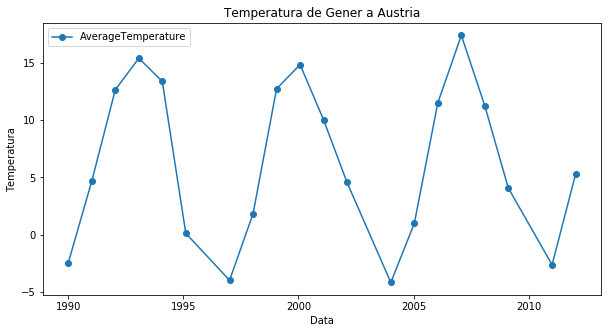

In [102]:
ind=42
array=[]
resultPlot2 = resultPlot[(resultPlot['Country'] == "Austria")&(resultPlot['Type'] == "CO2")]
for index, row in resultPlot2.iterrows():
    if(index%ind==0):
        array.append(row)
labels = ['Data','AverageTemperature','Country','Type']
dadesPlot=pd.DataFrame.from_records(array, columns=labels)
fig, ax = plt.subplots()
ax.set(ylabel='Temperatura',
       title='Temperatura de Gener a Austria')
dadesPlot.plot(kind='line',marker='o',x='Data',y='AverageTemperature',figsize=(10,5),ax=ax)

In [103]:
print (dadesPlot)

       Data  AverageTemperature  Country Type
0   1990.01              -2.443  Austria  CO2
1   1991.03               4.694  Austria  CO2
2   1992.05              12.666  Austria  CO2
3   1993.07              15.421  Austria  CO2
4   1994.09              13.393  Austria  CO2
5   1995.11               0.118  Austria  CO2
6   1997.01              -3.984  Austria  CO2
7   1998.03               1.834  Austria  CO2
8   1999.05              12.749  Austria  CO2
9   2000.07              14.867  Austria  CO2
10  2001.09              10.040  Austria  CO2
11  2002.11               4.562  Austria  CO2
12  2004.01              -4.173  Austria  CO2
13  2005.03               0.994  Austria  CO2
14  2006.05              11.521  Austria  CO2
15  2007.07              17.422  Austria  CO2
16  2008.09              11.259  Austria  CO2
17  2009.11               4.075  Austria  CO2
18  2011.01              -2.632  Austria  CO2
19  2012.03               5.287  Austria  CO2


In [97]:
print (resultPlot2)

        Data         Value  Country Type  AverageTemperature
0    1990.01  62297.166000  Austria  CO2              -2.443
3    1990.02  63417.203939  Austria  CO2               2.713
6    1990.03  64354.776643  Austria  CO2               5.391
9    1990.04  65120.698769  Austria  CO2               5.462
12   1990.05  65725.784968  Austria  CO2              12.561
15   1990.06  66180.849897  Austria  CO2              14.199
18   1990.07  66496.708208  Austria  CO2              15.992
21   1990.08  66684.174557  Austria  CO2              16.846
24   1990.09  66754.063597  Austria  CO2              10.564
27   1990.10  66717.189983  Austria  CO2               8.224
30   1990.11  66584.368368  Austria  CO2               2.021
33   1990.12  66366.413408  Austria  CO2              -3.402
36   1991.01  66074.139756  Austria  CO2              -2.544
39   1991.02  65718.362066  Austria  CO2              -4.620
42   1991.03  65309.894994  Austria  CO2               4.694
45   1991.04  64859.5531